### Necessary Imports and Installs

In [1]:
!pip install opendatasets

In [2]:
#Cloning repo provided by Kaggle competition including useful tools for working with data

!rm -rf GLC
!git clone https://github.com/maximiliense/GLC

Cloning into 'GLC'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 383 (delta 119), reused 170 (delta 63), pack-reused 155
Receiving objects: 100% (383/383), 10.57 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [3]:
#Importing various modules needed
#Kaggle competition provided some of these modules as ones to import
# https://www.kaggle.com/code/tlorieul/geolifeclef2022-data-loading-and-visualization/notebook


import tensorflow as tf
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, \
BatchNormalization, Normalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import scale
import time
from collections import defaultdict
import math
import copy
import opendatasets as od

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

Populating the interactive namespace from numpy and matplotlib


# Dataset

## Download Dataset

In [4]:
#downloading the dataset provided by Kaggle competition

data = od.download("https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kennedysalamat
Your Kaggle Key: ··········


100%|██████████| 57.6G/57.6G [06:07<00:00, 168MB/s]



Extracting archive ./geolifeclef-2022-lifeclef-2022-fgvc9/geolifeclef-2022-lifeclef-2022-fgvc9.zip to ./geolifeclef-2022-lifeclef-2022-fgvc9


## Load Dataset from file

In [ ]:
#The following code section was provided by the Kaggle competition as an example of how to load the data
#Citation:
#https://www.kaggle.com/code/tlorieul/geolifeclef2022-data-loading-and-visualization/notebook


In [5]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = "./geolifeclef-2022-lifeclef-2022-fgvc9/"

In [6]:
import time
hours = 4
#time.sleep(60*60*hours)

In [7]:
ls -L $DATA_PATH

metadata/      patches-fr/      patches-us/     rasters/
observations/  patches_sample/  pre-extracted/  sample_submission.csv


In [8]:
ls $DATA_PATH/observations

observations_fr_test.csv   observations_us_test.csv
observations_fr_train.csv  observations_us_train.csv


In [9]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH + "/observations/observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH + "/observations/observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))


print("Number of observations for training: {}".format(len(df_obs)))

# let's have a look at the data
df_obs.head()

#print(x[0])

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [10]:
### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH + "/observations/observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH + "/observations/observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))


print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


In [11]:
ls $DATA_PATH/patches-fr/00

00/  07/  14/  21/  28/  35/  42/  49/  56/  63/  70/  77/  84/  91/  98/
01/  08/  15/  22/  29/  36/  43/  50/  57/  64/  71/  78/  85/  92/  99/
02/  09/  16/  23/  30/  37/  44/  51/  58/  65/  72/  79/  86/  93/
03/  10/  17/  24/  31/  38/  45/  52/  59/  66/  73/  80/  87/  94/
04/  11/  18/  25/  32/  39/  46/  53/  60/  67/  74/  81/  88/  95/
05/  12/  19/  26/  33/  40/  47/  54/  61/  68/  75/  82/  89/  96/
06/  13/  20/  27/  34/  41/  48/  55/  62/  69/  76/  83/  90/  97/


In [12]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH + "/metadata/landcover_suggested_alignment.csv", sep=";")
df_suggested_landcover_alignment.head()

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


In [13]:
from GLC.data_loading.common import load_patch

patch = load_patch(10171444, DATA_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


In [14]:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
#patch = load_patch(10171444, DATA_PATH, landcover_mapping=landcover_mapping)

### Train/Val Split Labels
Retrieve the train/val split provided.

In [15]:
#obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
#obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values
print(obs_id_train)
print(obs_id_val)
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

[10561949 10131188 10799362 ... 22068172 22068173 22068176]
[10297014 10610548 10545927 ... 22068163 22068165 22068174]
Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


In [16]:
print(obs_id_train == obs_id_val)
print(y_train == y_val)

False
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [17]:
#Sample SimpleImputer code was provided by the Kaggle competition: https://www.kaggle.com/code/tlorieul/geolifeclef2022-baselines-and-submission/notebook
# Kennedy modified to preserve the column and row headings 
# Resources that were consulted to modify the code, properly apply SimpleImputer, and understand indexing in Pandas:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://pandas.pydata.org/docs/user_guide/indexing.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_axis.html


from sklearn.impute import SimpleImputer
#imp = SimpleImputer(
#    missing_values=np.nan,
#    strategy="constant",
#    fill_value=np.finfo(np.float32).min,
#)
df_env = pd.read_csv("./geolifeclef-2022-lifeclef-2022-fgvc9/pre-extracted/environmental_vectors.csv", sep=";", index_col="observation_id")
a  = df_env.loc(0)
columnsNamesArr = df_env.columns.values
#print(columnsNamesArr)
rowNames = df_env.index.values
#print(rowNames)
my_imputer = SimpleImputer()
#print(df_env.shape)
#print(my_imputer.fit_transform(df_env)[0])

df_env = pd.DataFrame(my_imputer.fit_transform(df_env))
df_env.set_axis(rowNames, axis='index', inplace = True)
df_env.set_axis(columnsNamesArr, axis='columns', inplace = True)
#print(df_env.shape)

df_env.head()



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,-5.083334,1361.0,148.0,68.0,20.667326,416.0,245.0,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,2.116667,1109.0,113.0,64.0,15.231100,314.0,226.0,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,-1.083333,1288.0,144.0,71.0,17.713518,386.0,268.0,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,6.250000,877.0,97.0,48.0,21.229550,279.0,157.0,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,0.766667,1102.0,128.0,52.0,21.077870,348.0,214.0,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0


In [18]:
# obs_id_test = df_obs_test.index[:].values


#### Get subset

In [19]:
# CHOOSE SUBSET FOR 30 Labels
# Originally, Nathalie's code chose the first n labels
# Kennedy re-wrote this code to select 30 labels with 
# between 2000 and 3000 observation ids associated
# These 30 labels were used for training/val/and testing.
# Kaggle currently provides a "training" and "validation" subset
# We needed a test subset.
# Kennedy wrote the code such that it withheld 10% of observations ids
# for each label to create the testing set, and used the remaining 90% of the 
# training subset as the training set. The entire validation subset whose labels
# matched the training/test labels was selected.

import random
subset_size = 0
obs_list = list()
obs_test_list = list()
import numpy as np
# iterate over a subset of the labels
m = 0
for y in (np.unique(y_train)[:]):
    #print("in")
    # for each label, retrieve all corresponding observation ids
    obs = df_obs.index[(df_obs["species_id"] == y)]
   


    #print(len(obs))
    #print(counter)
    #print(obs)
    #print(len(obs))
    if (len(obs) >= 2000 and len(obs) <= 3000):
      t = set(df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "train")].values)
      m += len(t)
      ten_perc = int(len(t)/10)
      random.seed(3)
      test = random.sample(t, ten_perc)
      train = t-set(test)
      #print(train)
      #print("here")
      obs_test_list.append(list(test))
      obs_list.append(list(train))
      subset_size += 1
    if (subset_size >= 30):
      #print("break")
      break
print(m)   
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_train = np.concatenate(obs_list)
obs_id_test = np.concatenate(obs_test_list)
gps_train = np.concatenate((df_obs.loc[obs_id_train]["latitude"].values, df_obs.loc[obs_id_train]["longitude"].values))
# obtain the labels in the right order 
y_train = df_obs.loc[obs_id_train]["species_id"].values
y_test = df_obs.loc[obs_id_test]["species_id"].values
print(y_train.size)

# 

subset_size = 8
obs_list_1 = list()
print(y_val.size)

# iterate over a subset of the labels
counter = 0
print(y_val[0])
for y in (np.unique(y_val)[:]):
    # for each label, retrieve all corresponding observation ids
    if (y in y_train):
      #obs = df_obs.index[df_obs["species_id"] == y].values
      v = df_obs.index[(df_obs["species_id"] == y) & (df_obs["subset"] == "val")].values
      obs_list_1.append(v)
# we now have a numpy array of all observation ids corresponding to this subset of labels
obs_id_val = np.concatenate(obs_list_1)

# obtain the labels in the right order 
y_val = df_obs.loc[obs_id_val]["species_id"].values
gps_val = np.concatenate((df_obs.loc[obs_id_val]["latitude"].values, df_obs.loc[obs_id_val]["longitude"].values))

70294
63278


In [20]:
print(y_test.size)

7016


In [23]:
print(y_val.size)
print(obs_id_val == obs_id_train)

1831
False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [24]:
# Nathalie's code to map the labels to the proper values and shuffle them 

map_labels = dict()
i = 0
for l in np.unique(y_train):
  map_labels[l] = i
  i += 1
print(map_labels)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}


In [25]:
y_train_normalized = np.zeros(np.shape(y_train), dtype = 'int64')

for i in range(len(y_train)):
  y_train_normalized[i] = map_labels[y_train[i]]

print(y_train_normalized)

[ 0  0  0 ... 29 29 29]


In [26]:
from sklearn.utils import shuffle
obs_id_train_new, y_train_normalized = shuffle(obs_id_train, y_train_normalized)

print(y_train_normalized)

[ 7 19  5 ...  5  8 27]


In [27]:
map_labels = dict()
i = 0
for l in np.unique(y_val):
  map_labels[l] = i
  i += 1
print(map_labels)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}


In [28]:
y_val_normalized = np.zeros(np.shape(y_val), dtype = 'int64')

for i in range(len(y_val)):
  y_val_normalized[i] = map_labels[y_val[i]]

from sklearn.utils import shuffle
obs_id_val_new, y_val_normalized = shuffle(obs_id_val, y_val_normalized)
print(y_val_normalized)

[ 7 29 16 ... 16  6  2]


In [29]:
map_labels = dict()
i = 0
for l in np.unique(y_test):
  map_labels[l] = i
  i += 1
print(map_labels)

y_test_normalized = np.zeros(np.shape(y_test), dtype = 'int64')

for i in range(len(y_test)):
  y_test_normalized[i] = map_labels[y_test[i]]

from sklearn.utils import shuffle
obs_id_test_new, y_test_normalized = shuffle(obs_id_test, y_test_normalized)
print(y_test_normalized)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}
[ 5 13 18 ... 22 20  0]


####PATCH GENERATOR

In [ ]:
#Custom Patch Generator for RGB images only 


In [30]:

import threading

class Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()

        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            patch = load_patch(self.obs_ids[i], DATA_PATH, data='all')
            X_batch.append(patch[0])
            y_batch.append(self.labels[i])

        with self.lock:
            return np.asarray(X_batch), np.array(y_batch)

In [31]:
#Custom generator to take in environmental vector data as well as all 
# types of satellite data. Used for multimodal ResNet

import threading

class Environmental_Patches_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, obs_ids, labels, batch_size) :
        self.obs_ids = obs_ids
        self.labels = labels
        self.batch_size = batch_size
        #self.gps = gps
        #self.extractor = extractor
        #print("INIT")
        # to make the generator thread safe 
        self.lock = threading.Lock()

    def __len__(self) :
        return (np.ceil(len(self.obs_ids) / float(self.batch_size))).astype(int)
  
    # returns one batch
    def __getitem__(self, idx) :
        X_batch = list()
        y_batch = list()
        X_env_batch = list()

        #print("ONE BATCH")
        for i in range(idx * self.batch_size, (idx+1) * self.batch_size):
            if i >= len(self.obs_ids): break
            
            rgb, near_ir, landcover, altitude = load_patch(self.obs_ids[i], DATA_PATH, data='all')
            ni = near_ir.reshape(256, 256, 1)
            lc = landcover.reshape(256, 256, 1)
            alt = altitude.reshape(256, 256, 1)

            patch = np.concatenate((rgb, ni, lc, alt), axis=2)

  
            #cs = MinMaxScaler()
            #print("PATCH GENERATOR")
            #print((df_env.loc[self.obs_ids[i]].values).shape)
            #print(cs.fit_transform(df_env.loc[self.obs_ids[i]].values).shape)
            #k = input()
            X_env_batch.append(df_env.loc[self.obs_ids[i]].values)
            #X_env_batch.append(df_env[self.obs_ids[i], :])
            #X_env_batch.append(cs.fit_transform(df_env.loc[self.obs_ids[i]].values.reshape(-1,1)))
            X_batch.append(patch)
            y_batch.append(self.labels[i])

            



        with self.lock:
        
            
            #return {'input_1': np.asarray(X_batch), 'input_2': np.asarray(X_env_batch)}, np.asarray(np.array(y_batch))
            #return np.asarray(X_batch), np.array(y_batch)
            return (np.asarray(X_batch), np.asarray(X_env_batch)), np.array(y_batch)

### ResNet From Scratch

Citation: ResNet from Scratch was build following these tutorials:

Conv_net and identity_block code snippets from: https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/
https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691


In [32]:
import tensorflow as tf

#CODE FOR THIS IDENTITY_BLOCK AND CONV_NET WAS FROM: https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/
# I experimented with decreasing the number of Conv2Ds in the convolutional layer by 1, but that 
# seemed to give worse results so it was reverted to the below which seems to be the standard.
#In the future, could add another convolution in the identity_block as a experiment, since that's what
# it seems the second link above suggests to maintain longer skip connections. 

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #print("A")
  x = tf.keras.layers.Conv2D(filter[1], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])

  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape, num_classes):
  x_input = tf.keras.layers.Input(input_shape)
  x = tf.keras.layers.Rescaling(1./255)(x_input)
  x = tf.keras.layers.ZeroPadding2D(padding = (3,3))(x)

  
  #print("a")
  x = tf.keras.layers.Conv2D(64, 7 , strides = 2, padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (64, 64))
  #print('c')
  x = identity_block(x, (64, 64))

  #print('d')
  x = conv_net(x, (128, 128))
  x = identity_block(x, (128, 128))
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

  model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "resnet_from_scratch")

  return model






#### ResNet Modified to take in image + tabular 

Used the code from above + modified to take multimodal input. Now takes two input sizes -- 1 is (256, 256, 6) for the 6 channels for all of the satellite image data. The second input is (27) for the tabular bioclimatic and pedologic data.

In [33]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #print("A")
  x = tf.keras.layers.Conv2D(filter[1], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])

  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  x_input = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x = tf.keras.layers.ZeroPadding2D(padding = (3,3))(x_input)

  #print("a")
  x = tf.keras.layers.Conv2D(64, 7, strides = 2, padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (2,2), padding = "same")(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (64, 64))
  #print('c')
  x = identity_block(x, (64, 64))

  #print('d')
  x = conv_net(x, (128, 128))
  x = identity_block(x, (128, 128))
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))
  x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnetold_tab_plus_image")

  return model






#### RES_1
Res_1 was modified from above (which used the same code tutorials cited above) to apply an initial Conv2D on the input to rescale it to to be 224 x 224 x 3. This model also implemented several techniques to combat overfitting including Dropout and Data Augmentation. Kernel and Bias L2 regularizers were also added to several layers (code snippet from: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/). The model was simplified from above and consisted of a few alternating conv_net and identity_block components. 

In [34]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("here")
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])
  #print('err')
  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def res_1(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  #x_input = tf.keras.
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x_input = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x_input)
  aug = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  
  #x = tf.keras.layers.ZeroPadding2D(padding = (9,9))(aug)

  x = tf.keras.layers.Conv2D(64, 7, strides = 2)(aug)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (32, 32))
  #print('c')
  x = identity_block(x, (32, 32))

  #print('d')
  x = conv_net(x, (128, 128))
  x = tf.keras.layers.Dropout(0.1)(x)
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet1_tab_plus_image")

  return model






#### RES_2
Res_2 was modified from above. It was the same as Res_1, lacking the initial Conv2D rescaling layer.

In [35]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  print("here")
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])
  print('err')
  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def res_2(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  #x_input = tf.keras.
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  #x_input = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x_input)
  aug = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  
  #x = tf.keras.layers.ZeroPadding2D(padding = (9,9))(aug)

  x = tf.keras.layers.Conv2D(64, 7, strides = 2)(aug)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (32, 32))
  #print('c')
  x = identity_block(x, (32, 32))

  #print('d')
  x = conv_net(x, (128, 128))
  x = tf.keras.layers.Dropout(0.1)(x)
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet2_tab_plus_image")

  return model






In [36]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  print("here")
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])
  print('err')
  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  #print("B")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2, padding = "same")(x)
  #print("C")
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #print("D")
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #print("E")
  x_skip = tf.keras.layers.Conv2D(filter[1], (1,1), strides = 2, padding = "same")(x_skip)
  x = tf.keras.layers.Add()([x, x_skip])
  #print("F")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def rgb_res(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  #x_input = tf.keras.
  x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x_input = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x_input)
  aug = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  
  #x = tf.keras.layers.ZeroPadding2D(padding = (9,9))(aug)

  x = tf.keras.layers.Conv2D(64, 7, strides = 2)(aug)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (32, 32))
  #print('c')
  x = identity_block(x, (32, 32))

  #print('d')
  x = conv_net(x, (128, 128))
  x = tf.keras.layers.Dropout(0.1)(x)
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)
  x2 = tf.keras.layers.Dropout(0.1)(x2)
  x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet_tab_plus_image_rgb")

  return model






#### Pre-Trained ResNet-50

CNN Multimodal

In [37]:
def multi_modal_cnn(input_shape1, input_shape2, num_classes):
    #with mirrored_strategy.scope():

        # Inputs
        patch_input = tf.keras.layers.Input(shape=input_shape1, dtype='float32')
        tabular_input = tf.keras.layers.Input(shape=input_shape2, dtype='float32')  

        # Augment data
    #     augmented = data_augmentation_for_visualization(patch_input)

        # From Scratch model
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(patch_input)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((1, 1), padding='same')(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)      

        # Add Dense layers for images
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)

        # Add Dense layers for Tabular data
        y = tf.keras.layers.Dense(512, activation='relu')(tabular_input)
        y = tf.keras.layers.Dense(256, activation='relu')(y)

        # Concatenate Image and tabular weights
        z = tf.keras.layers.Concatenate(axis=1)([x, y])

        # Add Classification Head
        z = tf.keras.layers.Dense(128, activation='relu')(z)
        classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(z)

        # Define inputs and outputs
        model = tf.keras.Model(inputs=[patch_input, tabular_input], outputs=classifier)

        return model

In [38]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.Rescaling(1./255),
        #tf.keras.layers.Resizing((256,256,6)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

#### For Images (Includes RGB, near IR, landcover, altitude) + Tabular (environmental vectors)

In [39]:
BATCHSIZE = 128
train_generator = Environmental_Patches_Generator(obs_id_train_new, y_train_normalized, BATCHSIZE)
print("HERRE")
val_generator = Environmental_Patches_Generator(obs_id_val_new, y_val_normalized, BATCHSIZE)

print(y_train_normalized)
# converting our train dataset to tf.data.Dataset
#tf_train_dataset = tf.data.Dataset.from_generator(
#    lambda: train_generator ,  # Our generator 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32) , # How we're expecting our output dtype
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) # How we're expecting our output shape
#)

#tf_val_dataset = tf.data.Dataset.from_generator(
#    lambda: val_generator , 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32),
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) 
#)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#num_classes = len(set(df_obs['species_id']))
print(len(set(df_obs['species_id'])))
num_classes = 30

input_shape1 = (256, 256, 6)
input_shape2 = (27)
model5 = res_1(input_shape1, input_shape2, num_classes)
# Compile model
model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )
model5.summary()


HERRE
[ 7 19  5 ...  5  8 27]
17037
here
err
here
err
here
err
Model: "resnet1_tab_plus_image"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 109, 109, 64  9472        ['data_augmentation[1][0]']      
                                )                                                                 
              

#### Pre-Trained All Images Code

Conv2D code

In [40]:
BATCHSIZE = 128
train_generator = Patches_Generator(obs_id_train_new, y_train_normalized, BATCHSIZE)
print("HERRE")
val_generator = Patches_Generator(obs_id_val_new, y_val_normalized, BATCHSIZE)

print(y_train_normalized)
# converting our train dataset to tf.data.Dataset
#tf_train_dataset = tf.data.Dataset.from_generator(
#    lambda: train_generator ,  # Our generator 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32) , # How we're expecting our output dtype
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) # How we're expecting our output shape
#)

#tf_val_dataset = tf.data.Dataset.from_generator(
#    lambda: val_generator , 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32),
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) 
#)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#num_classes = len(set(df_obs['species_id']))
print(len(set(df_obs['species_id'])))
num_classes = 30

input_shape1 = (256, 256, 3)
input_shape2 = (27)
model6 = rgb_res(input_shape1, input_shape2, num_classes)
# Compile model
model6.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )
model6.summary()


HERRE
[ 7 19  5 ...  5  8 27]
17037
here
err
here
err
here
err
Model: "resnet_tab_plus_image_rgb"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 109, 109, 64  9472        ['data_augmentation[3][0]']      
                                )                                                                 
           

In [41]:
BATCHSIZE = 128
train_generator = Environmental_Patches_Generator(obs_id_train_new, y_train_normalized, BATCHSIZE)
print("HERRE")
val_generator = Environmental_Patches_Generator(obs_id_val_new, y_val_normalized, BATCHSIZE)

print(y_train_normalized)
# converting our train dataset to tf.data.Dataset
#tf_train_dataset = tf.data.Dataset.from_generator(
#    lambda: train_generator ,  # Our generator 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32) , # How we're expecting our output dtype
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) # How we're expecting our output shape
#)

#tf_val_dataset = tf.data.Dataset.from_generator(
#    lambda: val_generator , 
#    output_types = ({'input_1': tf.float32 , 'input_2': tf.float32}, tf.float32),
#    output_shapes = ({'input_1': [BATCH_SIZE, 256 , 256, 6], 'input_2': [BATCH_SIZE, 29]} , [BATCH_SIZE, ]) 
#)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#num_classes = len(set(df_obs['species_id']))
print(len(set(df_obs['species_id'])))
num_classes = 30

input_shape1 = (256, 256, 6)
input_shape2 = (27)
model7 = res_2(input_shape1, input_shape2, num_classes)
# Compile model
model7.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
              ]
              )
model7.summary()


HERRE
[ 7 19  5 ...  5  8 27]
17037
here
err
here
err
here
err
Model: "resnet2_tab_plus_image"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, None, None,   0          ['input_9[0][0]']                
                                None)                                                             
                                                                                                  
 conv2d_34 (Conv2D)             (None, 125, 125, 64  18880       ['data_augmentation[5][0]']      
              

#### For GPS

#### Run Model

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results = model5.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 414s 808ms/step - loss: 18.0281 - accuracy: 0.0984 - top-5-accuracy: 0.3047 - val_loss: 6.5146 - val_accuracy: 0.1447 - val_top-5-accuracy: 0.4014
Epoch 2/50
495/495 [==============================] - 275s 555ms/step - loss: 7.4388 - accuracy: 0.1366 - top-5-accuracy: 0.3871 - val_loss: 5.3183 - val_accuracy: 0.1267 - val_top-5-accuracy: 0.4424
Epoch 3/50
495/495 [==============================] - 274s 554ms/step - loss: 5.6182 - accuracy: 0.1612 - top-5-accuracy: 0.4393 - val_loss: 4.8636 - val_accuracy: 0.1540 - val_top-5-accuracy: 0.4539
Epoch 4/50
495/495 [==============================] - 273s 551ms/step - loss: 4.8876 - accuracy: 0.1858 - top-5-accuracy: 0.4854 - val_loss: 4.6699 - val_accuracy: 0.1557 - val_top-5-accuracy: 0.4659
Epoch 5/50
495/495 [==============================] - 275s 554ms/step - loss: 4.5008 - accuracy: 0.2057 - top-5-accuracy: 0.5200 - val_loss: 4.4341 - val_accuracy: 0.1813 - val_top-5-accuracy: 0.4965

In [43]:
map_labels = dict()
i = 0
for l in np.unique(y_test):
  map_labels[l] = i
  i += 1
print(map_labels)

y_test_normalized = np.zeros(np.shape(y_test), dtype = 'int64')

for i in range(len(y_test)):
  y_test_normalized[i] = map_labels[y_test[i]]

from sklearn.utils import shuffle
obs_id_test_new, y_test_normalized = shuffle(obs_id_test, y_test_normalized)
print(y_test_normalized)
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model5.evaluate(test_generator)

{5: 0, 68: 1, 125: 2, 129: 3, 223: 4, 553: 5, 570: 6, 605: 7, 679: 8, 692: 9, 739: 10, 979: 11, 1075: 12, 1155: 13, 1916: 14, 2196: 15, 2524: 16, 2821: 17, 2950: 18, 2992: 19, 3253: 20, 4940: 21, 4991: 22, 4999: 23, 5025: 24, 5086: 25, 5168: 26, 5192: 27, 5207: 28, 5228: 29}
[17  8 26 ... 14 18  0]
55/55 [==============================] - 44s 811ms/step - loss: 3.1685 - accuracy: 0.2754 - top-5-accuracy: 0.6112


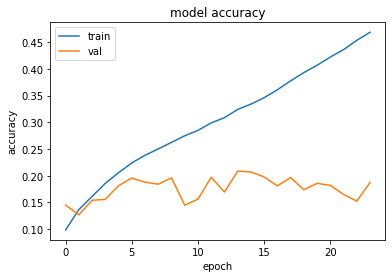

In [44]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['accuracy'])
plt.plot(train_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

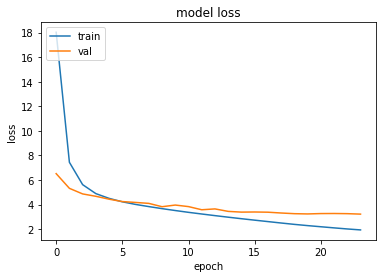

In [45]:
# summarize history for loss
plt.plot(train_results.history['loss'])
plt.plot(train_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

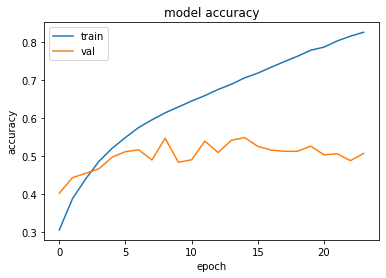

In [46]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results.history['top-5-accuracy'])
plt.plot(train_results.history['val_top-5-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results1 = model6.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 277s 554ms/step - loss: 15.1592 - accuracy: 0.0988 - top-5-accuracy: 0.3048 - val_loss: 6.1845 - val_accuracy: 0.1453 - val_top-5-accuracy: 0.4407
Epoch 2/50
495/495 [==============================] - 271s 546ms/step - loss: 6.9314 - accuracy: 0.1376 - top-5-accuracy: 0.3912 - val_loss: 5.2045 - val_accuracy: 0.1185 - val_top-5-accuracy: 0.4320
Epoch 3/50
495/495 [==============================] - 272s 548ms/step - loss: 5.4477 - accuracy: 0.1680 - top-5-accuracy: 0.4452 - val_loss: 4.8463 - val_accuracy: 0.1376 - val_top-5-accuracy: 0.4724
Epoch 4/50
495/495 [==============================] - 272s 549ms/step - loss: 4.7992 - accuracy: 0.1909 - top-5-accuracy: 0.4928 - val_loss: 4.6757 - val_accuracy: 0.1278 - val_top-5-accuracy: 0.4691
Epoch 5/50
495/495 [==============================] - 271s 548ms/step - loss: 4.4352 - accuracy: 0.2103 - top-5-accuracy: 0.5263 - val_loss: 4.3257 - val_accuracy: 0.1720 - val_top-5-accuracy: 0.5243

In [48]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model6.evaluate(test_generator)

55/55 [==============================] - 30s 535ms/step - loss: 2.9710 - accuracy: 0.2620 - top-5-accuracy: 0.6028


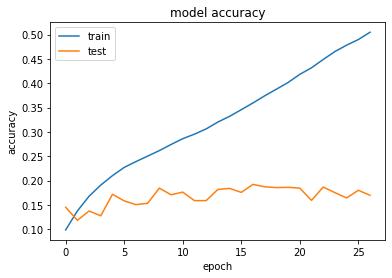

In [49]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results1.history['accuracy'])
plt.plot(train_results1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

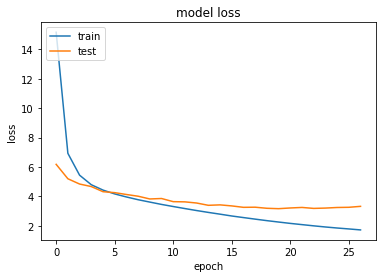

In [50]:
# summarize history for loss
plt.plot(train_results1.history['loss'])
plt.plot(train_results1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

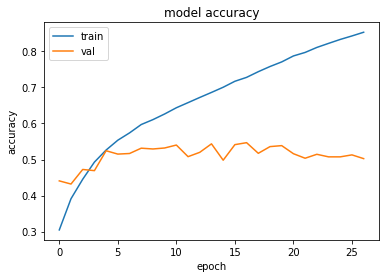

In [51]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results1.history['top-5-accuracy'])
plt.plot(train_results1.history['val_top-5-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, 
                                            verbose=0, mode='auto', baseline=None, restore_best_weights=True)
train_results2 = model7.fit(
    #train_ds,
    train_generator,
    validation_data = val_generator,
    #tf_train_dataset,
    #validation_data= val_ds,
    #validation_data = tf_val_dataset,
    epochs = 50,
    callbacks=[early_stop])
#)
# callbacks=[early_stop])

Epoch 1/50
495/495 [==============================] - 276s 550ms/step - loss: 11.5090 - accuracy: 0.0981 - top-5-accuracy: 0.3047 - val_loss: 5.5292 - val_accuracy: 0.1502 - val_top-5-accuracy: 0.4402
Epoch 2/50
495/495 [==============================] - 270s 546ms/step - loss: 5.9488 - accuracy: 0.1403 - top-5-accuracy: 0.3998 - val_loss: 4.8167 - val_accuracy: 0.1660 - val_top-5-accuracy: 0.4560
Epoch 3/50
495/495 [==============================] - 271s 547ms/step - loss: 4.9441 - accuracy: 0.1725 - top-5-accuracy: 0.4616 - val_loss: 4.6962 - val_accuracy: 0.1382 - val_top-5-accuracy: 0.4566
Epoch 4/50
495/495 [==============================] - 270s 545ms/step - loss: 4.4856 - accuracy: 0.1961 - top-5-accuracy: 0.5027 - val_loss: 4.3396 - val_accuracy: 0.1535 - val_top-5-accuracy: 0.5019
Epoch 5/50
495/495 [==============================] - 271s 547ms/step - loss: 4.1832 - accuracy: 0.2142 - top-5-accuracy: 0.5303 - val_loss: 4.1980 - val_accuracy: 0.1529 - val_top-5-accuracy: 0.5128

In [53]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model7.evaluate(test_generator)

55/55 [==============================] - 30s 536ms/step - loss: 3.7078 - accuracy: 0.2214 - top-5-accuracy: 0.5855


In [54]:
test_generator = Environmental_Patches_Generator(obs_id_test_new, y_test_normalized, BATCHSIZE)
result = model7.evaluate(test_generator)

55/55 [==============================] - 29s 529ms/step - loss: 3.7078 - accuracy: 0.2214 - top-5-accuracy: 0.5855


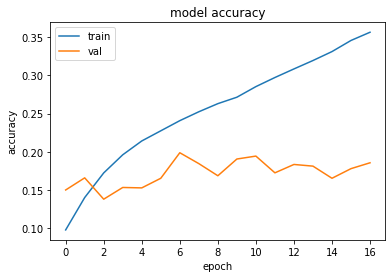

In [55]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results2.history['accuracy'])
plt.plot(train_results2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

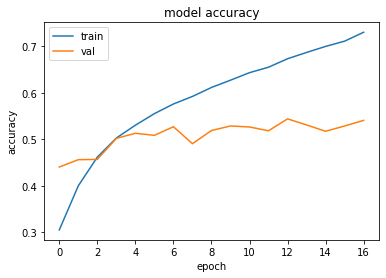

In [56]:
# summarize history for accuracy
#FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(train_results2.history['top-5-accuracy'])
plt.plot(train_results2.history['val_top-5-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

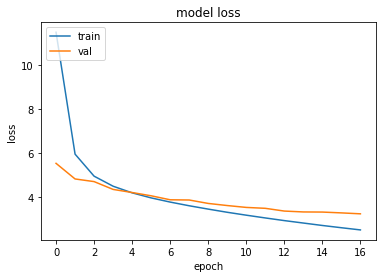

In [57]:
# summarize history for loss
plt.plot(train_results2.history['loss'])
plt.plot(train_results2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
#code to save to csv
hist_df = pd.DataFrame(train_results1.history) 
# or save to csv: 
hist_csv_file = 'rgb.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [62]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

def identity_block(x, filter):
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  print("here")
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filter[0], (3,3), padding = "same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, x_skip])
  print('err')
  x = tf.keras.layers.Activation('relu')(x)

  return x

def conv_net(x, filter):
  
  x_skip = x
  x = tf.keras.layers.Conv2D(filter[0], (3,3), strides = 2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.keras.layers.Activation('relu')(x)
  #x = tf.keras.layers.Conv2D(filter[0], (3,3))(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  x_skip = tf.keras.layers.Conv2D(filter[1], (3,3), strides = 2)(x_skip)
  print("HE")
  print("A")
  x = tf.keras.layers.Add()([x, x_skip])
  print("now error")
  x = tf.keras.layers.Activation('relu')(x)

  return x

#input 1 is for image data, input 2 is for tabular data
def my_res(input_shape1, input_shape2, num_classes):
  x_input = tf.keras.layers.Input(input_shape1)
  #x_input = tf.keras.layers.Rescaling(1./255)(x_input)
  x_input = tf.keras.layers.Conv2D(3, kernel_size=(33, 33), activation='relu')(x_input)
  aug = data_augmentation(x_input)
  tab_input = tf.keras.layers.Input(input_shape2)
  
  #x = tf.keras.layers.ZeroPadding2D(padding = (9,9))(aug)

  x = tf.keras.layers.Conv2D(64, 7, strides = 2)(aug)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(x)

  #print(x.shape)
  #print('b')
  x = conv_net(x, (32, 32))
  #print('c')
  x = identity_block(x, (32, 32))

  #print('d')
  x = conv_net(x, (128, 128))
  x = tf.keras.layers.Dropout(0.25)(x)
  x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))
  #x = identity_block(x, (128, 128))

  x = conv_net(x, (256, 256))
  x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))
  #x = identity_block(x, (256, 256))

  x = tf.keras.layers.AveragePooling2D(padding = "same")(x)
  x = tf.keras.layers.Flatten()(x)
  
  #x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)


  # Add Dense layers for Tabular data
  #y = tf.keras.layers.Dense(512)(tab_input)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #y = tf.keras.layers.Dense(256)(x)
  #y = tf.keras.layers.Dense(256)(tab_input)
  #FROM stackoverflow
  
  x2 = tf.keras.layers.Flatten()(tab_input)
  x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  x2 = tf.keras.layers.Dropout(0.25)(x2)
  x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x2)

  #FIRST RUN
  #x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
  #x2 = tf.keras.layers.Dense(256, activation='relu')(x2)
  #2 = tf.keras.layers.Dense(6400, activation='relu')(x2)

  #print(x[0])
  #print(x2[0])
  #k = input()
  #print(x.shape)
  #print(x2.shape)
  
  #k = input()
  # Concatenate Image and tabular weights
  z = tf.keras.layers.Concatenate(axis=1)([x, x2])

  # Add Classification Head
  #z = tf.keras.layers.Dense(128)(z)
  classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

  #classifier = tf.keras.layers.Dense(num_classes, name='outputs', activation='softmax')(x)
  model = tf.keras.models.Model(inputs = [x_input, tab_input], outputs = classifier, name = "resnet_tab_plus_image")

  return model






In [58]:
generate_submission_file("./submissions/new", df_obs_test.index, s_pred)

NameError: ignored